## Modelling and prediction of chaotic systems using Echo State Network 

## 1. Introduction

In this notebook, we will study how to implement a particular form of reservoir computing, called Echo State Network, to model the dynamics of a chaotic system.
The first test case will be the Lorenz system which is a prototypical chaotic sytem. It is governed by:
\begin{equation}
     \frac{dx}{dt} = \sigma(y-x), \hspace{11pt} \frac{dy}{dt} = x(\rho-z) -y, \hspace{11pt} \frac{dz}{dt} = xy-\beta z
 \end{equation}
 The dataset considered here has parameters $\sigma=10$, $\rho=28$ and $\beta = 8/3$.
 
The objective here is to train an ESN so that it can reproduce the dynamics of the Lorenz system.

## 2. Code

### 2.1 Library import

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import math_ops
import h5py
import time
from util import *
from mpl_toolkits import mplot3d
#from ESN import EchoStateRNNCell
#from Lorenz_eq import *

### 2.2 Import the ESN class
See ESN.ipynb for the implementation of the ESN.
The current implementation uses the Recurrent Neural Network class existing in tensorflow for convenience.
Details of the exact architecture of the ESN are given in the course notes.

In [2]:
%run ESN.ipynb # import the ESN class

Set random seeds for reproducibility of runs

In [3]:
# Set random seeds for reproducibility of runs
# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

### 2.3 Read and treatment of the data
The data is a relatively long run of the Lorenz system which was generated using an explicit Euler scheme with $\Delta t = 0.01$.

In [4]:
## for Lorenz system
hf = h5py.File('./Data/Lorenz63_T200_DT001.h5','r') # this data has 20000 timestep, DT=0.01, T=200 and Nx = 3
case = 'Lorenz'
t = np.array(hf.get('t1'))
x = np.array(hf.get('x1'))
y = np.array(hf.get('y1'))
z = np.array(hf.get('z1'))
u_exact = np.array((x,y,z)).T
del x,y,z

# physical parameters of the Lorenz system
dt = 0.01
Nx = 3
sigma = 10.0
rho = 28.0
beta = 8. / 3.

hf.close()
num_inputs = u_exact.shape[1]
Nx = u_exact.shape[1]

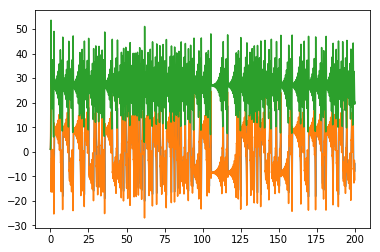

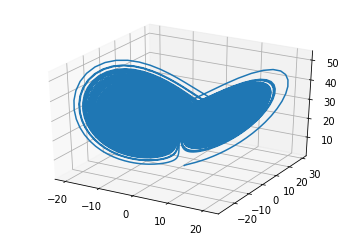

In [5]:
plt.figure()
plt.plot(t,u_exact[:,0])
plt.plot(t,u_exact[:,1])
plt.plot(t,u_exact[:,2])

plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(u_exact[:,0],u_exact[:,1],u_exact[:,2])

One can see from this trajectory in phase space that the Lorenz system "orbits" around 2 attractors and randomly jumps from one orbit to the other.
 
For what follows, only a small subset of that dataset will be used for the training of the ESN.

### Split of the data into training part
Here, we put ourselves in the small data paradigm.
As a result, we will only keep 1000 timesteps which roughly corresponds to 10 Lyapunov time for the Lorenz system.

We will use the following terminology for the split of the data:
 - Training: data with known inputs/outputs used to "teacher-forced" the ESN; the outputs of the ESN are collected and used to compute $W_{out}$.
 - Validation: data with known inputs/outputs; the inputs is fed to the ESN and the outputs of the ESN are compared to the real outputs for validation of the computation of $W_{out}$ (this is still a teacher-forced situation).
 - prediction: The ESN is loopbacked to itself to provide a natural response; this natural response is compared to the exact evolution of the Lorenz system for the same initial conditions.

In [6]:
## Parameters for the split of the training/validation ----------------------------
batches = 1 # number of batches for training
stime = 500 # total sample size for training + validation

begin = 50 # begin of training (wash out at the start to remove the transient of the reservoir)
end = 500 # has to be equal or smaller than stime - this can be used for a "validation" of the ESN
horizon = 500 # duration of the prediction (for time beyond training)

cut1 = 1000 # to get rid of the initial transient in the simulation
cut2 = 1000+stime+horizon+1 # 
u_exact = u_exact[np.arange(cut1,cut2),:] # we keep only the necessary data

### Treatment of inputs -----------------------------------------------------------
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float64")
wave = u_exact[:stime+1,:].astype("float64")

rnn_inputs = wave[:-1,:].reshape(1,stime, num_inputs)

### Treatment of output ------------------------------------------------------------
num_outputs = Nx ## 
rnn_target = wave[1:,:]
rnn_target = rnn_target.reshape(stime, num_outputs).astype("float64")

del wave

### 2.4 Definition of the metaparameters for the ESN
The metaparameters of the ESN are defined in the course notes.

In [7]:
### ESN metaparameters for Lorenz system
num_units = 200
decay = 1.0 # for leaky-ESN (0.1)
rho_spectral = 0.4 # spectral radius of Wecho (0.4)
sigma_in = 0.15 # scaling of input weight (0.15)
degree = 3.0 # average number of connections of a unit to other units in reservoir (3.0)
sparseness = 1. - degree / (num_units - 1.) # sparseness of W
lmb = 0.0001 # Ridge/Thikonov regularization factor (0.0001)
activation = lambda x: math_ops.tanh(x) # the activation function of the ESN

### 2.5 Definition of the tensorflow graph

In [8]:
tf.reset_default_graph()
graph = tf.Graph()

rng = np.random.RandomState(random_seed)
# Initialize the ESN cell
cell = EchoStateRNNCell(num_units=num_units, 
                        num_inputs=num_inputs,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        sparseness = sparseness, # sparsity of the echo matrix
                        rng=rng)

### Training/Teacher-forced part of the graph
In this part of the graph, the inputs of the ESN are provided - hence it is called a "teacher-forced" training.
This test ultimately just allows to assess the "one-step prediction" capability of the ESN, i.e., whether its prediction $\widehat{y}(t+\Delta t)$ given $u(t)$ is close to $y(t+\Delta t)$.

In [9]:
inputs = tf.placeholder(tf.float64, [batches, None, num_inputs])
init_state = tf.placeholder(tf.float64, [1, num_units])

Ytarget_tf = tf.placeholder(tf.float64,[None, num_outputs])

# Build the graph (for training on a time sequence - teacher forcing)
outputs,_ = tf.nn.dynamic_rnn(cell=cell,inputs=inputs,initial_state=init_state,dtype=tf.float64)
#outputs = tf.reshape(outputs, [stime, num_units])   
outputs = outputs[0,:,:]

Wout_tf = tf.Variable(np.random.rand(num_units,num_outputs),dtype=tf.float64,trainable=True)
Ytrain_tf = tf.matmul(outputs,Wout_tf)

### Natural prediction part of the graph
In this part of the graph, the output of the ESN is looped back as its input to obtain its "autonomous response",
i.e. $\widehat{y}(t+\Delta t)$ given $\widehat{y}(t)$ as input.
This autonomous response is compared to the exact evolution in the data and
this comparison allows to examine whether the trained ESN is a good approximation of the Lorenz system.

In [10]:
# Build the part of the graph for future prediction (natural response of the ESN)
# This is made so as to have an "entry" points via the inputF,stateF variables
inputF = tf.reshape(Ytrain_tf[-1,:],[1, num_inputs])
stateF = tf.placeholder(tf.float64, [1, num_units])
stateL,_ = cell(inputs=inputF, state=stateF)
#Wout_tf = tf.placeholder(tf.float64, [num_units, num_outputs])
Ypred_tf = tf.matmul(stateL,Wout_tf)

# Build the graph extension for prediction
state_pred = stateL
Ypred_all_tf = []
Ypred_all_tf.append(Ypred_tf)
for it in range(1,horizon):
    state_pred,_ = cell(inputs=Ypred_tf,state=state_pred)
    Ypred_tf = tf.matmul(state_pred,Wout_tf)
    Ypred_all_tf.append(Ypred_tf)
outputs_pred = tf.reshape(Ypred_all_tf, [horizon, num_outputs])

### 2.6 Data-only training of the ESN
This section has 3 major parts:
1. Get the states associated to the input time series
2. Compute $W_{out}$ via ridge regression
3. Compute the output of the ESN using the $W_{out}$ compute in 2.

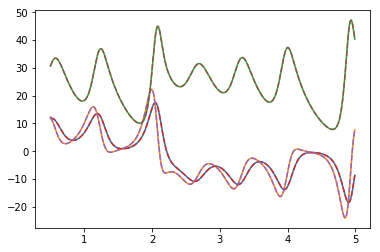

In [11]:
config = tf.ConfigProto()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# training of the ESN
rnn_init_state = np.zeros([batches, num_units], dtype="float64")

stored_outputs  = sess.run(outputs, feed_dict={inputs:rnn_inputs,
                                        init_state:rnn_init_state}) # get the reservoir states for the input

XX_train = stored_outputs[begin:end,:].astype('float64') # Washout
st =  np.reshape(stored_outputs[-1,:],[1, num_units]).astype('float64') # save the last state for future prediction

# compute via Ridge regression, save and load the resulting Wout
Wout = np.matmul( 
    np.linalg.inv(np.matmul(np.transpose(XX_train), XX_train) +
        lmb*np.eye(num_units)),
    np.matmul(np.transpose(XX_train), rnn_target[begin:end,:]) )
Wout0 = Wout
Wout_tf.load(Wout,sess)

## get the estimation from the ESN on training data
Yout = sess.run(Ytrain_tf,feed_dict={outputs:stored_outputs})

plt.figure()
plt.plot(t[begin:end],rnn_target[begin:end,:])
plt.plot(t[begin:end],Yout[begin:end,:],'--')
# We can see above that training an ESN which performs well on this training data is relatively straightforward.

#### Teacher/input-forced ESN

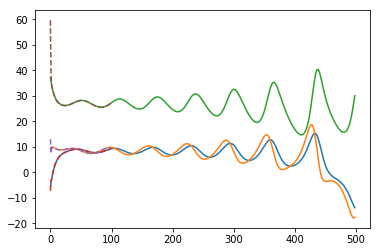

In [12]:
new_input = u_exact[stime+1:stime+100+1,:]
new_input = new_input.reshape(1,new_input.shape[0],new_input.shape[1])
Ytest = sess.run(Ytrain_tf,feed_dict={inputs:new_input,
                                        init_state:rnn_init_state})

plt.figure()
plt.plot(u_exact[stime+2:stime+horizon+2,:])
plt.plot(Ytest,'--')

# Similarly, when the ESN is in an input-forced situation, the ESN provides excellent agreement with the actual evolution of the Lorenz system.

#### Natural response of the ESN

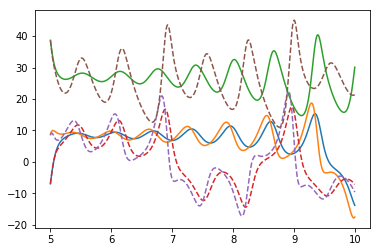

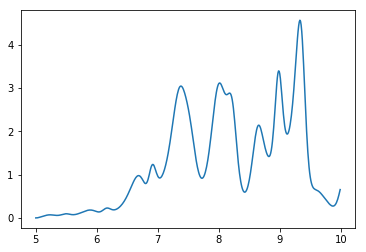

In [13]:
inn = Yout[-1,:]
# future prediction
inn = inn.reshape((1,num_outputs)).astype('float64')

Ypred_ESN =  sess.run(outputs_pred,feed_dict={stateF:st, inputF:inn})
Epred_ESN = np.sum((Ypred_ESN-u_exact[stime+1:stime+horizon+1,:num_outputs])**2.,1)  / np.mean((u_exact[stime+1:stime+horizon+1,:num_outputs]**2.))

plt.figure()
plt.plot(t[end:end+horizon],u_exact[stime+1:stime+horizon+1,:])
plt.plot(t[end:end+horizon],Ypred_ESN,'--')
plt.figure()
plt.plot(t[end:end+horizon],Epred_ESN)

# However, when looking at the natural response of the ESN, we can see that discrepancies between the ESN and the Lorenz system appears quite fast.

### 2.7 Physics informed part

In [ ]:
# def Lorenz_step_tf(Uin,sigma,rho,beta,dt):

We define here a new graph where the natural response of the ESN is computed and the values collected. The physical residual of this series is then computed and a loss function is defined based on the error on the training data and this physical residual. This loss function is then used in an optimizer to compute a new  Wout.

In [ ]:
# Build the graph extension for validation/optimization
Yval_tf = tf.matmul(stateL,Wout_tf)
state_val = stateL
valid_hor = 1000

## code the graph extension hereunder

# LOSS_TF = ...

Define the optimizer which minimize LOSS_TF

In [ ]:
# Define and initialize the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(LOSS_TF)
initialize_uninitialized(sess)

In [ ]:
## MODIFY THIS SECTION ACCORDING TO THE WAY YOU DEFINE THE LOSS_TF
## AND PROVIDE THE APPROPRIATE feed_dict to the sess.run

#opt_res = sess.run(LOSS_TF,feed_dict ={...})
#print(opt_res)

#for iopt in range(100):
#    sess.run(optimizer, feed_dict ={...})
#    opt_res = sess.run(LOSS_TF,feed_dict ={...})
#    if (iopt%50)==0:
#        print(opt_res)

plt.rcParams["figure.figsize"] = (15,7)
plt.figure()
plt.plot(t[end:end+horizon],u_exact[stime+1:stime+horizon+1,:])
plt.plot(t[end:end+horizon],Ypred_ESN,'--')
plt.figure()
plt.plot(t[end:end+horizon],Epred_ESN)

plt.show()

In [ ]:
Ypred_PIESN =  sess.run(outputs_pred,feed_dict={stateF:st, inputF:inn})
Epred_PIESN = np.sum((Ypred_PIESN-u_exact[stime+1:stime+horizon+1,:num_outputs])**2.,1)  / np.mean((u_exact[stime+1:stime+horizon+1,:num_outputs]**2.))
plt.rcParams["figure.figsize"] = (15,7)
plt.figure()
plt.subplot(1,2,1)
plt.plot(t[end:end+horizon],u_exact[stime+1:stime+horizon+1,:])
plt.plot(t[end:end+horizon],Ypred_PIESN,'--')
plt.subplot(1,2,2)
plt.plot(t[end:end+horizon],u_exact[stime+1:stime+horizon+1,:])
plt.plot(t[end:end+horizon],Ypred_ESN,'--')
plt.figure()
plt.plot(t[end:end+horizon],Epred_PIESN,'--')
plt.plot(t[end:end+horizon],Epred_ESN)

### Save results and trained ESN
The saving of the ESN consists in saving the $W_{in}$, $W$ and $W_{out}$ matrices and of the hyperparameters of the ESN and the random seed.
This ESN can be re-used for other predictions.

In [ ]:
fln = 'Lorenz_case.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('Epred_ESN',data=Epred_ESN)
hf.create_dataset('Ypred_ESN',data=Ypred_ESN)
hf.create_dataset('Yexact',data=u_exact[stime+1:stime+horizon+1,:])
hf.close()

fln_mod = 'Lorenz_model.h5'
cell.save_ESN(fln_mod,Wout,st,lmb)
hf = h5py.File(fln_mod,'a')
hf.create_dataset('Wout0',data=Wout0)
hf.close()